In [3]:
import os
# from PIL import Image
import PIL.Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle
import torch
from datasets import Dataset, Image
from torch.utils.data import DataLoader
from typing import List, Union, Tuple
from transformers import CLIPProcessor, CLIPModel

import faiss
# import pinecone

import kagglehub
import random

In [4]:
# Download latest version
dataset_path = kagglehub.dataset_download("adityajn105/flickr30k")
print("Path to dataset files:", dataset_path)
dataset_path = os.path.join(dataset_path, "Images")
print("Path to images:", dataset_path)

Path to dataset files: C:\Users\david\.cache\kagglehub\datasets\adityajn105\flickr30k\versions\1
Path to images: C:\Users\david\.cache\kagglehub\datasets\adityajn105\flickr30k\versions\1\Images


## **Creating Image Embedding Using OpenAI Clip**

In [ ]:
device = "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
preprocess = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

c:\Users\david\Documents\git\SemanticSearch\venv\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\david\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [6]:
images_list = os.listdir(dataset_path)
images_paths = [os.path.join(dataset_path, image) for image in images_list if '.jpg' in image]
images_paths.sort()
print(images_paths[:5])

['C:\\Users\\david\\.cache\\kagglehub\\datasets\\adityajn105\\flickr30k\\versions\\1\\Images\\1000092795.jpg', 'C:\\Users\\david\\.cache\\kagglehub\\datasets\\adityajn105\\flickr30k\\versions\\1\\Images\\10002456.jpg', 'C:\\Users\\david\\.cache\\kagglehub\\datasets\\adityajn105\\flickr30k\\versions\\1\\Images\\1000268201.jpg', 'C:\\Users\\david\\.cache\\kagglehub\\datasets\\adityajn105\\flickr30k\\versions\\1\\Images\\1000344755.jpg', 'C:\\Users\\david\\.cache\\kagglehub\\datasets\\adityajn105\\flickr30k\\versions\\1\\Images\\1000366164.jpg']


Number of images: 31783
Example image path: C:\Users\david\.cache\kagglehub\datasets\adityajn105\flickr30k\versions\1\Images\3562903245.jpg


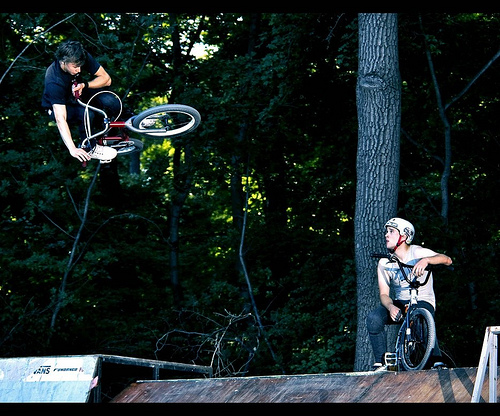

In [7]:
print("Number of images:", len(images_paths))
example_image = images_paths[random.randint(0, len(images_paths))]
print("Example image path:", example_image)
im = PIL.Image.open(example_image)
display(im)
# 2148982.jpg

In [8]:
example_image
example_image_name = os.path.basename(example_image)
print(example_image_name)

3562903245.jpg


In [9]:
captions_df = pd.read_csv('captions.csv')
example_image_name = os.path.basename(example_image)
print(captions_df[captions_df['image'] == example_image_name].caption.values)

[' A bike rider sits and watches as a fellow rider does a jump off a ramp .'
 ' Two young men on bicycles one is doing a flip while the other watches'
 ' Two trick bikers , one is jumping at the top of a ramp .'
 ' A man watches another man do a bicycle trick .'
 ' Two young men do cycle figures on ramp .']


In [ ]:
#####
### LONG PROCESS
#####
def encode_images(images: Union[List[str], List[PIL.Image.Image]], batch_size: int):
    def transform_fn(el):
        if isinstance(el['image'], PIL.Image.Image):
            imgs = el['image']
        else:
            imgs = [Image().decode_example(_) for _ in el['image']]
        return preprocess(images=imgs, return_tensors='pt')
        
    dataset = Dataset.from_dict({'image': images})
    dataset = dataset.cast_column('image',Image(decode=False)) if isinstance(images[0], str) else dataset       
    dataset.set_format('torch')
    dataset.set_transform(transform_fn)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    image_embeddings = []
    pbar = tqdm(total=len(images) // batch_size, position=0)
    with torch.no_grad():
        for batch in dataloader:
            batch = {k:v.to(device) for k,v in batch.items()}
            image_embeddings.extend(model.get_image_features(**batch).detach().cpu().numpy())
            pbar.update(1)
        pbar.close()
    return np.stack(image_embeddings)

vector_embedding = np.array(encode_images(images_paths,32))

#####
### LONG PROCESS
#####

  0%|          | 1/993 [00:01<32:13,  1.95s/it]

KeyboardInterrupt: 

## **Saving Image Embeddings**

In [15]:
with open('flicker30k_image_embeddings.pkl','wb') as f:
    pickle.dump(vector_embedding, f)

## **Opening Saved Image Embeddings**

In [11]:
import pickle
with open('flicker30k_image_embeddings.pkl', 'rb') as fp:
    vector_embedding = pickle.load(fp)

## **Building Index Using FAISS**

In [12]:
def encode_text( text: List[str], batch_size: int):
    device =  "cpu"
    dataset = Dataset.from_dict({'text': text})
    dataset = dataset.map(lambda el: preprocess(text=el['text'], return_tensors="pt",
                                                        max_length=77, padding="max_length", truncation=True),
                            batched=True,
                            remove_columns=['text'])
    dataset.set_format('torch')
    dataloader = DataLoader(dataset, batch_size=batch_size)
    text_embeddings = []
    pbar = tqdm(total=len(text) // batch_size, position=0)
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            text_embeddings.extend(model.get_text_features(**batch).detach().cpu().numpy())
            pbar.update(1)
        pbar.close()
    return np.stack(text_embeddings)

In [13]:
index = faiss.IndexFlatIP(vector_embedding.shape[1])
index.add(vector_embedding)

In [14]:
print(index)
print(vector_embedding.shape)

<faiss.swigfaiss_avx2.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x000001C4D37791A0> >
(31783, 512)


## **Text to Image Search**

In [15]:
search_text = "basketball game"
with torch.no_grad():
    text_search_embedding = encode_text([search_text], batch_size=32)
text_search_embedding = text_search_embedding/np.linalg.norm(text_search_embedding, ord=2, axis=-1, keepdims=True)

Map: 100%|██████████| 1/1 [00:00<00:00, 230.94 examples/s]
1it [00:00, 17.65it/s]


In [16]:
distances, indices = index.search(text_search_embedding.reshape(1, -1), 5)

: 

In [14]:
distances, indices = index.search(text_search_embedding.reshape(1, -1), 5)
distances = distances[0]
indices = indices[0]

indices_distances = list(zip(indices, distances))
indices_distances.sort(key=lambda x: x[1])  # Sort based on the distances

print(indices_distances)

: 

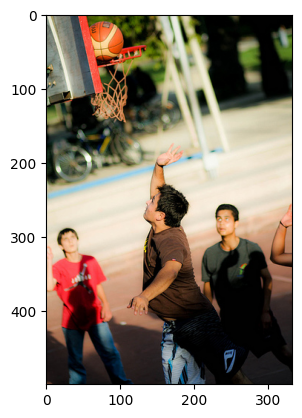

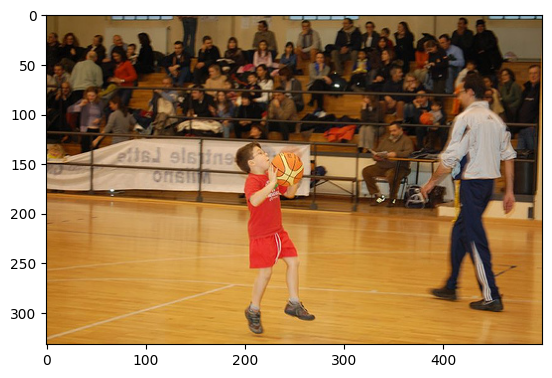

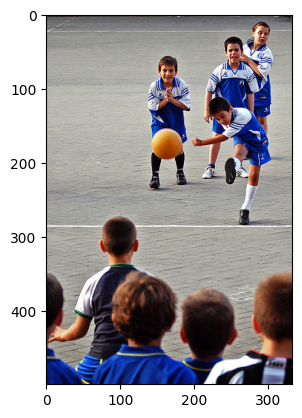

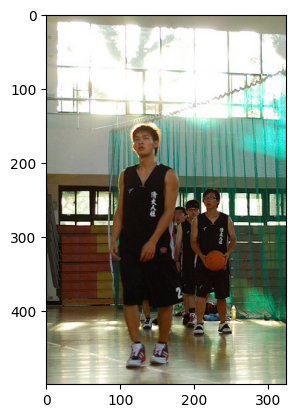

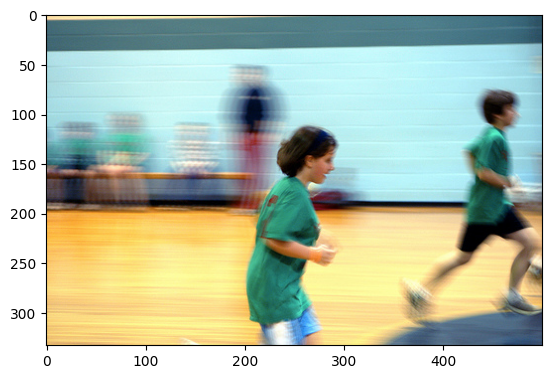

In [73]:
from PIL import Image
for idx, distance in indices_distances:
    path = image_path[idx]
    im = Image.open(path)
    plt.imshow(im)
    plt.show()